<a href="https://colab.research.google.com/github/rwante/Facelift/blob/main/Facelift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Veriseti3.zip" -d "/content/"

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils,to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AvgPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet169, DenseNet201
from keras.optimizers import SGD
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7

In [ ]:
data_dir = "/content/Veriseti3/"
images = []
car_types = []
for car_type in ["Hyundai_Faceliftli","Hyundai_Faceliftsiz","Nissan_Faceliftli","Nissan_Faceliftsiz","Passat_Faceliftli","Passat_Faceliftsiz"]:
    car_dir = data_dir + car_type
    car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
    for filename in car_files:
        if filename.endswith('jpg'):
            try:
                image = cv2.imread(filename)
                images.append(cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC))
                car_types.append(car_type)
            except Exception as e:
                pass
images = np.array(images)
car_types = np.array(car_types)
lbl = LabelEncoder()
car_types_encoded = lbl.fit_transform(car_types)
data = np.asarray(images, dtype="float")
data2= np.asarray(car_types_encoded, dtype="float")
np.savez("car.npz",DataX=data)
np.savez("cartypes.npz",DataX=data2)

In [ ]:
path = "car.npz"
with np.load(path) as data:
    # load DataX as train_data
    train_data = data['DataX']
data = train_data
path = "cartypes.npz"
with np.load(path) as data2:
    # load DataX as train_data
    train_label = data2['DataX']
label = train_label

print(label)
print(data)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=0.3, random_state=0)
x_train = x_train / 255
x_val = x_val / 255
y_train = to_categorical(y_train)
# y_val=to_categorical(y_val)
y_val2 = to_categorical(y_val)
datagen = ImageDataGenerator(rotation_range=20,
		horizontal_flip=True)
datagen.fit(x_train)
print(x_val.shape)
x_train.shape

In [ ]:
def build_ResNet50(input_tensor_shape):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_tensor_shape)

    x_model = base_model.output

    x_model = AvgPool2D(name='globalaveragepooling2d')(x_model)

    x_model = Dense(1024, activation='relu', name='fc1_Dense')(x_model)
    x_model = Dropout(0.35, name='dropout_1')(x_model)
    x_model = Flatten()(x_model)
    x_model = Dense(256, activation='relu', name='fc2_Dense')(x_model)
    x_model = Dropout(0.35, name='dropout_2')(x_model)

    predictions = Dense(6, activation='softmax', name='output_layer')(x_model)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [ ]:
input_tensor_shape = (64, 64, 3)

model2 = build_ResNet50(input_tensor_shape)

model2.summary()

In [ ]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(
    monitor='loss',  # Metric to be measured
    factor=.1,  # Factor by which learning rate will be reduced
    patience=3,
    # No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
    min_lr=1e-5)
callbacks_list=[lrr]
model2.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
nb_epoch = 100

batch_size = 256
fitted_model2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = 38,
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val2),callbacks=[callbacks_list]
                    )
from sklearn.metrics import classification_report,confusion_matrix
y_pred = model2.predict(x_val)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)
print(y_val)
report = classification_report(y_val,y_pred)
print(report)
print(confusion_matrix(y_val,y_pred))
plt.plot(fitted_model2.history['accuracy'])
plt.plot(fitted_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

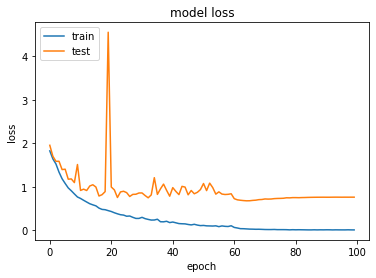

In [ ]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model2.history['loss'])
plt.plot(fitted_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()